<a href="https://colab.research.google.com/github/Osman-Dawood/Assinment-2/blob/main/Lab3_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [3]:
import pandas as pd
import numpy as np

## Download the Data

In [4]:
housing = pd.read_csv('https://raw.githubusercontent.com/Osman-Dawood/IAI600-Lab2/refs/heads/main/housing.csv')

## Create a Test Set

In [5]:
 # set income category based on median income
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

In [6]:
from sklearn.model_selection import StratifiedShuffleSplit
    # stratified sampling
split = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    # get train and test dataset
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [7]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

# Prepare the Data for Machine Learning Algorithms:

1. Dropping the Target Variable

2. Creating Labels

Feature Set (housing): This DataFrame will be used as the input features for training the machine learning model.

Labels (housing_labels): This Series will be used as the target variable that the model will learn to predict.

In [8]:
# Dropping the Target Variable
housing_tr= strat_train_set.drop("median_house_value", axis=1)
# Creates a copy of the selected column to avoid modifying the original DataFrame.
housing_labels = strat_train_set["median_house_value"].copy()

## Data Cleaning
Most machine learning algorithms cannot work with missing features. For example, we noticed earlier that the total_bedrooms
attribute has some missing values.

#In the book 3 options for solution are listed:
```python
housing.dropna(subset=["total_bedrooms"])    # option 1: Get rid of the corresponding districts.
housing.drop("total_bedrooms", axis=1)       # option 2: Get rid of the whole attribute.
median = housing["total_bedrooms"].median()  # option 3: Set the missing values to some value (zero, the mean, the median, etc.). This is called imputation
housing["total_bedrooms"].fillna(median, inplace=True)


We go for option 3 since it is the least destructive, but instead of the
preceding code, we will use a handy Scikit-Learn class: SimpleImputer to find the median of the total_bedrooms, which will be used automatically in the following Transformation Pipelines.

Now remove the text attribute (ocean_proximity) because median can only be calculated on numerical attributes:

In [9]:
housing_num = housing_tr.drop("ocean_proximity", axis=1)

Let's create a custom transformer to add extra attributes:



In [10]:
from sklearn.base import BaseEstimator, TransformerMixin

# column index
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

## Transformation Pipelines






ColumnTransformer can transform  the numerical attributes & category/text attributes both together

In [11]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import OneHotEncoder

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

cat_pipeline = Pipeline([
     ('imputer', SimpleImputer(strategy='most_frequent')),
        ('cat_encoder', OneHotEncoder()),
    ])
full_pipeline = ColumnTransformer([
        ('num', num_pipeline, num_attribs),
        ('cat', cat_pipeline, cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing_tr)

In [12]:
housing_prepared.shape

(16512, 16)

# Select and Train a Model

## Training and Evaluating on the Training Set

Linear Regression

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

lin_reg = LinearRegression()
# training by fitting inputs and outputs
lin_reg.fit(housing_prepared, housing_labels)

# Prediction error
housing_predictions = lin_reg.predict(housing_prepared)
mse = mean_squared_error(housing_labels, housing_predictions)
rmse = np.sqrt(mse)
print("\n  Prediction RMSE error in :", rmse)

# let's try the full preprocessing pipeline on a few training instance
some_data = housing_tr.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

# Compare
print("\n  Predictions:", list(lin_reg.predict(some_data_prepared).round(-2)))
print("  Labels:     ", list(some_labels.round(-2)))



  Prediction RMSE error in : 68080.91134759795

  Predictions: [175300.0, 157100.0, 106800.0, 345400.0, 170100.0]
  Labels:      [124900.0, 152800.0, 70200.0, 404300.0, 133500.0]


Decision Tree Regressor

In [14]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)

# training by fitting inputs and outputs
tree_reg.fit(housing_prepared, housing_labels)

# Prediction error
housing_predictions = tree_reg.predict(housing_prepared)
mse = mean_squared_error(housing_labels, housing_predictions)
rmse = np.sqrt(mse)
print("\n  Prediction RMSE error in :", rmse)

# let's try the full preprocessing pipeline on a few training instance
some_data = housing_tr.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

# Compare
print("\n  Predictions:", list(tree_reg.predict(some_data_prepared).round(-2)))
print("  Labels:     ", list(some_labels.round(-2)))


  Prediction RMSE error in : 0.0

  Predictions: [124900.0, 152800.0, 70200.0, 404300.0, 133500.0]
  Labels:      [124900.0, 152800.0, 70200.0, 404300.0, 133500.0]


This model gave zero prediction error, so either it is absolutely perfector it badly overfitted the data which is more likely.To be sure  we use  





This model gave zero prediction error, so either it is absolutely perfector it badly overfitted the data which is more likely.To be sure  we use Cross-Validation technique.





## Better Evaluation Using Cross-Validation

In [15]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [16]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [71307.02864327 65697.07817545 70856.93461192 71400.41442832
 70810.30712456 70146.49271354 68692.26287204 74034.76209993
 70781.33705998 65346.56358997]
Mean: 69907.31813189601
Standard deviation: 2525.1842643565196


The decision tree has an RMSE of about 69907 when cv=10 used (the training set split into 10 nonoverlapping subsets called folds, then it trains and evaluates the decision tree model 10 times, picking a different fold for evaluation every time and using the other 9 folds for training).

Using Cross-Validation with the previous Linear Regression model

In [17]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [69511.08384131 66614.66918395 68512.67886164 72545.20977016
 68030.07509804 67465.62788331 66348.97824628 68040.24849087
 68191.00543456 67646.38945915]
Mean: 68290.59662692761
Standard deviation: 1656.964020521763


Random Forest Regressor

In [18]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

# Prediction error
housing_predictions = forest_reg.predict(housing_prepared)
mse = mean_squared_error(housing_labels, housing_predictions)
rmse = np.sqrt(mse)
print("\n  Prediction RMSE error in :", rmse)

# let's try the full preprocessing pipeline on a few training instance
some_data = housing_tr.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

# Compare
print("\n  Predictions:", list(forest_reg.predict(some_data_prepared).round(-2)))
print("  Labels:     ", list(some_labels.round(-2)))


  Prediction RMSE error in : 18679.016032055308

  Predictions: [143100.0, 147900.0, 77100.0, 389700.0, 138600.0]
  Labels:      [124900.0, 152800.0, 70200.0, 404300.0, 133500.0]


The Random Forest Regressor has a RMSE of  18685 which is much lower, meaning that there’s still quite alot of overfitting going on.

Cross-Validation with the previous Random
Forest Regressor

In [19]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [51629.84378491 47804.21482027 48335.82160182 51056.58278853
 51861.08075697 51325.37485226 50292.69662722 49640.41684944
 49767.31743911 49255.36322443]
Mean: 50096.87127449516
Standard deviation: 1315.815957985624


Support Vector Regression SVR

In [20]:
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit(housing_prepared, housing_labels)

# Prediction error
housing_predictions = svm_reg.predict(housing_prepared)
mse = mean_squared_error(housing_labels, housing_predictions)
rmse = np.sqrt(mse)
print("\n  Prediction RMSE error in :", rmse)

# let's try the full preprocessing pipeline on a few training instance
some_data = housing_tr.iloc[:5].round(-2)
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
# Compare
print("\n  Predictions:", list(svm_reg.predict(some_data_prepared).round(-2)))
print("  Labels:     ", list(some_labels.round(-2)))


  Prediction RMSE error in : 110590.6616998264

  Predictions: [186500.0, 184700.0, 184800.0, 191100.0, 187300.0]
  Labels:      [124900.0, 152800.0, 70200.0, 404300.0, 133500.0]


The Random Forest model has an RMSE of about 50083.7 when cv=10 used, and still lowest among all the other three models as shown in the gragh below.



 After Using Cross-Validation (Validation Errors)

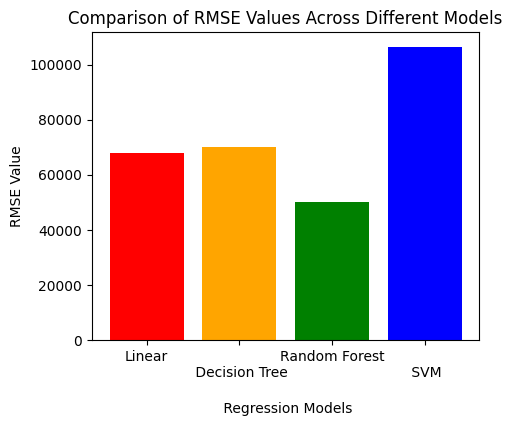

In [21]:
import matplotlib.pyplot as plt

models = ['Linear', '\n Decision Tree', 'Random Forest', '\n SVM']
rmse_values = [68035.6, 70008.5, 50083.7,  106385]
colors = ['red', 'orange', 'green', 'blue' ]

plt.figure(figsize=(5, 4))
plt.bar(models, rmse_values, color=colors)

plt.ylabel('RMSE Value')
plt.xlabel('\n Regression Models')
plt.title('Comparison of RMSE Values Across Different Models')
plt.show()

Among all the four ML models used the random forests look very promising for this task!So let us fine -tune it to find the  best hyperparameters for this model that may even give less error.

# Fine-Tune Your Model

## Linear Regression

Grid Search CV

In [22]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression

# Define the Linear Regression model
linear_model = LinearRegression()

# Define the hyperparameter grid for Grid Search
param_grid = {'copy_X': [True, False],
               'fit_intercept': [True, False],
               'n_jobs': [1, 5, 10, 15, None],
}

# Create the GridSearchCV object
lre_search = GridSearchCV(linear_model, param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the model to the training data
lre_search.fit(housing_prepared, housing_labels)

print(f"Best Parameters (Grid Search): {lre_search.best_params_}")

# Calculate RMSE from the negative MSE
negative_mse = lre_search.best_score_
rmse = np.sqrt(-negative_mse)  # Convert negative MSE to positive before taking the square root

print(f"Best Score (RMSE): {rmse}")

# Best model from Grid Search
lre_search.best_estimator_

Best Parameters (Grid Search): {'copy_X': True, 'fit_intercept': True, 'n_jobs': 1}
Best Score (RMSE): 68356.8141153719


LinearRegression(n_jobs=1)

Randomized Search CV

In [23]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression
import numpy as np

# Define the Linear Regression model
linear_model = LinearRegression()

# Define the hyperparameter grid for Randomized Search
param_distributions = {
    'copy_X': [True, False],
    'fit_intercept': [True, False],
    'n_jobs': [1, 5, 10, 15, None],
}

# Create the RandomizedSearchCV object
lre_random_search = RandomizedSearchCV(linear_model, param_distributions, n_iter=20, cv=5, scoring='neg_mean_squared_error', random_state=42)

# Fit the model to the training data
lre_random_search.fit(housing_prepared, housing_labels)

# Output the best parameters found
print(f"Best Parameters (Randomized Search): {lre_random_search.best_params_}")

# Calculate RMSE from the negative MSE
negative_mse = lre_random_search.best_score_
rmse = np.sqrt(-negative_mse)  # Convert negative MSE to positive before taking the square root

print(f"Best Score (RMSE): {rmse}")
# Best model from Randomized Search
lre_random_search.best_estimator_

Best Parameters (Randomized Search): {'n_jobs': 1, 'fit_intercept': True, 'copy_X': True}
Best Score (RMSE): 68356.8141153719


LinearRegression(n_jobs=1)

## Decision Tree Regressor

Grid Search *CV*

In [24]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid to search
param_grid = {
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [15, 20, 25]
}

tree_reg = DecisionTreeRegressor(random_state=42)

# train across 5 folds
t_grid_search = GridSearchCV(tree_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
t_grid_search.fit(housing_prepared, housing_labels)

# Output the best parameters and the best score
print("Best Parameters:", t_grid_search.best_params_)
print("Best Score (RMSE):", np.sqrt(-t_grid_search.best_score_))

# Best model from Grid Search
t_grid_search.best_estimator_

Best Parameters: {'max_depth': 15, 'min_samples_leaf': 20, 'min_samples_split': 2}
Best Score (RMSE): 58595.23198983305


DecisionTreeRegressor(max_depth=15, min_samples_leaf=20, random_state=42)

*Randomized* Search

In [25]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from scipy.stats import randint  # Import randint for sampling from integer distributions

# Define the Decision Tree Regression model
decision_tree_model = DecisionTreeRegressor()

# Define the hyperparameter distribution for Randomized Search
param_dist = {
    'max_depth': [None, 5, 10, 15, 20],  # Depth of the tree
    'min_samples_split': randint(2, 20),  # Minimum number of samples required to split an internal node (randomized)
    'min_samples_leaf': randint(1, 10),  # Minimum number of samples required to be at a leaf node (randomized)
}

# Create the RandomizedSearchCV object
dt_random_search = RandomizedSearchCV(decision_tree_model, param_dist, n_iter=50, cv=5, scoring='neg_mean_squared_error', random_state=42)

# Fit the model to the training data
dt_random_search.fit(housing_prepared, housing_labels)

# Output the best parameters found
print(f"Best Parameters (Randomized Search): {dt_random_search.best_params_}")

# Calculate RMSE from the negative MSE
negative_mse_dt = dt_random_search.best_score_
rmse_dt = np.sqrt(-negative_mse_dt)  # Convert negative MSE to positive before taking the square root

print(f"Best Score (RMSE): {rmse_dt}")

# Best model from Randomized Search
dt_random_search.best_estimator_


Best Parameters (Randomized Search): {'max_depth': 10, 'min_samples_leaf': 9, 'min_samples_split': 16}
Best Score (RMSE): 59493.196280446595


DecisionTreeRegressor(max_depth=10, min_samples_leaf=9, min_samples_split=16)

## Random Forest Regressor

Grid Search *CV*

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

param_grid = [
    # try 12 combinations of hyperparameters
    {'n_estimators': [50, 80, 120, 140], 'max_features': [8, 10, 12]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)

# train across 5 folds, that's a total of (12+6)*5=90 rounds of training
f_grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
f_grid_search.fit(housing_prepared, housing_labels)

# Output the best parameters and the best score
print("Best Parameters:", f_grid_search.best_params_)
print("Best Score (RMSE):", np.sqrt(-f_grid_search.best_score_))

# Best model from Grid Search
f_grid_search.best_estimator_

The mean test RMSE score for the best model hyperparameters is 49951, which is better than the
score you got earlier using the default hyperparameter values (which was 50096.) using ross-Validation.

However when the hyperparameter search space is large, it is perferred to use
Randomized SearchCV instead.

*Randomized* Search

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=8, high=20),
    }

forest_reg = RandomForestRegressor(random_state=42)
f_rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=50, cv=5, scoring='neg_mean_squared_error', random_state=42)
f_rnd_search.fit(housing_prepared, housing_labels)

# Output the best parameters and the best score
print("\n Best Parameters:", f_rnd_search.best_params_)
print("\n Best Score (RMSE):", np.sqrt(-f_rnd_search.best_score_))

# Best model from Grid Search
f_rnd_search.best_estimator_

The mean test RMSE score for the best model hyperparameters is 49206 for   {'max_features': 7, 'n_estimators': 180}, which is better than the
score we got earlier using Grid Search (which was 49951) with less number of iterations (n_iter=10).(Grid Search combinations were 18)

## SVM Regressor

Grid Search CV

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

param_grid = [
        {'kernel': ['linear'], 'C': [10., 30., 100., 300., 1000., 3000., 10000., 30000.0]},
        {'kernel': ['rbf'], 'C': [1.0, 3.0, 10., 30., 100., 300., 1000.0],
         'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]},
    ]

svm_reg = SVR()
svm_grid_search = GridSearchCV(svm_reg, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2)
svm_grid_search.fit(housing_prepared, housing_labels)

# Output the best parameters and the best score
print("\n Best Parameters:", svm_grid_search.best_params_)
print("\n Best Score (RMSE):", np.sqrt(-svm_grid_search.best_score_))

# Best model from Grid Search
svm_grid_search.best_estimator_

Randomized Search CV

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, reciprocal

# Note: gamma is ignored when kernel is "linear"
param_distribs = {
        'kernel': ['linear', 'rbf'],
        'C': reciprocal(20, 200000),
        'gamma': expon(scale=1.0),
    }

svm_reg = SVR()
svr_random_search = RandomizedSearchCV(svm_reg, param_distributions=param_distribs,
                                n_iter=50, cv=5, scoring='neg_mean_squared_error',
                                verbose=2, random_state=42)
svr_random_search.fit(housing_prepared, housing_labels)

# Output the best parameters and the best score
print("\n Best Parameters:", svr_random_search.best_params_)
print("\n Best Score (RMSE):", np.sqrt(-svr_random_search.best_score_))

# Best model from Grid Search
svr_random_search.best_estimator_

## Best Scores for the models After fine-tuning

In [ ]:
import matplotlib.pyplot as plt

models = ['Linear', '\n Decision Tree', 'Random Forest', '\n SVM']
rmse_values = [68356.8, 58595, 49281,  54623]
colors = ['red', 'orange', 'green', 'blue' ]

plt.figure(figsize=(5, 4))
plt.bar(models, rmse_values, color=colors)

plt.ylabel('RMSE Value')
plt.xlabel('\n Regression Models')
plt.title('Comparison of RMSE Values Across Different Models')
plt.show()

## Evaluate Your System on the Test Set

In [ ]:

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

# Transformation Pipelines
X_test_prepared = full_pipeline.transform(X_test)
# Best model with fine-tuned hyperparameters
final_model = RandomForestRegressor(max_features=8, n_estimators=140, random_state=42)
final_model.fit(X_test_prepared, y_test)

# Prediction error
f_housing_predictions = final_model.predict(X_test_prepared)
final_mse = mean_squared_error(y_test, f_housing_predictions)
rmse = np.sqrt(final_mse).round(-2)
print("\n  Prediction RMSE error in :", rmse)

# let's try the full preprocessing pipeline on a few training instance
x_data = X_test.iloc[:5]
y_labels = y_test.iloc[:5]
x_data_prepared = full_pipeline.transform(x_data)

# Compare
print("\n  Predictions:", list(final_model.predict(x_data_prepared).round(-2)))
print("  Labels:     ", list(y_labels.round(-2)))

## Analyze the Best Models and Their Errors

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression

# Fit a Random Forest Regressor to the data
forest = RandomForestRegressor(max_features=8, n_estimators=140, random_state=42)
forest.fit(housing_prepared, housing_labels)

# Use SelectFromModel to select important features
selector = SelectFromModel(forest, threshold="mean")  # Select features greater than the mean importance
selector.fit(housing_prepared, housing_labels)

# Transform the data to keep only important features
X_train_selected = selector.transform(housing_prepared)
X_test_selected = selector.transform(X_test_prepared)

print("Selected Features Shape:", X_train_selected.shape)
print("Selected Features Shape:", X_test_selected.shape)
